In [2]:
import qdrant_client
from llama_index.core import SimpleDirectoryReader
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex

In [ ]:
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

In [174]:
text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

In [72]:
from datasets import load_dataset
dataset = load_dataset("KrushiJethe/fashion_data")
train_data = dataset['train']

In [73]:
train_data

Dataset({
    features: ['image', 'Unnamed: 0', 'articleType', 'productDisplayName', 'articleType_label'],
    num_rows: 9300
})

In [109]:
from datasets import load_dataset
from PIL import Image
from llama_index.core import Document


dataset = load_dataset("KrushiJethe/fashion_data")
selected_data = dataset['train'].select(range(1000))

documents = []

for data in selected_data:
    product_description = data['productDisplayName']
    
    image = data['image']
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    
    image_path = f"images/image_{data['Unnamed: 0']}.png"
    image.save(image_path) 
    
    doc = Document(text=product_description, extra_info={"image_path": image_path})
    documents.append(doc)


In [23]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.embeddings.clip import ClipEmbedding
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

In [25]:
from llama_index.core import Settings
Settings.embed_model =embed_model

In [12]:
from llama_index.embeddings.clip import ClipEmbedding
image_embed_model = ClipEmbedding()

100%|████████████████████████████████████████| 338M/338M [25:24<00:00, 232kiB/s]


In [175]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core.indices import MultiModalVectorStoreIndex

image_documents = SimpleDirectoryReader("/Users/samvardhan/Desktop/DataEngineer/multimodal_search/llamaIndex_multimodal_example/images").load_data()
final_documents = documents + image_documents
index = MultiModalVectorStoreIndex.from_documents(
    final_documents,
    storage_context=storage_context,
    image_embed_model=image_embed_model,
)

In [35]:

from llama_index.multi_modal_llms.ollama import OllamaMultiModal
mm_model = OllamaMultiModal(model="llava:7b-v1.5-q4_1", request_timeout=200)

In [207]:
from llama_index.core.prompts import PromptTemplate
from llama_index.core.query_engine import SimpleMultiModalQueryEngine

qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(llm=mm_model, text_qa_template=qa_tmpl , verbose=True)

query_str =  "White and Brown colour sneaker "
response = query_engine.query(query_str)

In [208]:
response.metadata["text_nodes"]

[NodeWithScore(node=TextNode(id_='a141bdc6-1f1b-4582-b12d-a270f784ff26', embedding=None, metadata={'image_path': 'images/image_7155.png'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='e75e9fbc-dea8-46d0-b8b0-afe899d3f4ec', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'image_path': 'images/image_7155.png'}, hash='750f9b745fb4229f8dacdfde415e77a40f6f01c2ca7bc36100d472a56a924a58')}, text='ADIDAS White  Sports Shoe', mimetype='text/plain', start_char_idx=0, end_char_idx=25, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=0.7338820699263199)]

In [209]:
print(str(response))

 Adidas


In [167]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break

**Node ID:** a141bdc6-1f1b-4582-b12d-a270f784ff26<br>**Similarity:** 0.7338820699263199<br>**Text:** ADIDAS White  Sports Shoe<br>

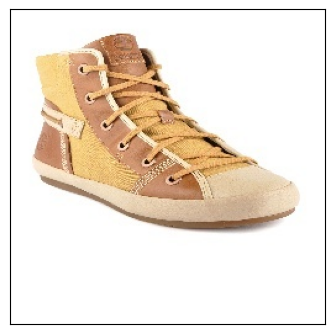

In [210]:
# show sources
from llama_index.core.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)